# Central Differential Privacy (Client-Side Clipping)

Central Differential Privacy (Client-Side Clipping) is a setup where the clipping of model updates happens on each client before sending the updates to the central server. After collecting all the clipped updates, the server aggregates them and adds noise centrally to enforce differential privacy.

In this setup:

- Clipping happens locally on the client — helping reduce the influence of outlier updates early.

- Noise is added by the server — simplifying coordination of privacy guarantees.

The specific strategy used here is:

## ViT: DifferentialPrivacyClientSideFixedClipping

This strategy enforces a fixed clipping norm on all clients before updates are sent, ensuring consistency across client contributions and helping the server apply a uniform DP guarantee during aggregation.

<br><p>

----

In [1]:
%load_ext autoreload
%load_ext watermark
    
%autoreload 2
%watermark --python -p torch,flwr

Python implementation: CPython
Python version       : 3.12.10
IPython version      : 9.1.0

torch: 2.6.0
flwr : 1.18.0



--------

## Loading Dependencies

In [ ]:
import os
import sys
sys.path.append("../..")

import ray
import time

from transformers import ViTForImageClassification

from logging import ERROR

from flwr.common import ndarrays_to_parameters, Context 
from flwr.client import Client, ClientApp
from flwr.client.mod import fixedclipping_mod
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import DifferentialPrivacyClientSideFixedClipping, FedAvg
from flwr.simulation import run_simulation

from src.config import ExperimentName
from src.paths import RAY_LOG_DIR
from src.FL_client import MedicalImageClient
from src.FL_server import weighted_average, build_evaluate_fn
from src.local_utility import load_yaml_config, set_device, prepare_FL_dataset, get_weights

from src.tracker import reset_base_memory_csv

In [ ]:
# Replace with appropritate values

data_name_ = 'alzheimer' #"skin_lesions" #
base_type_ = "ViT"           
exp_name_ = "CDP-CF"
num_labels_ = 4
experiment_name_ = ExperimentName.FL_CDP_CF_VIT

In [ ]:
DEVICE = set_device()
reset_base_memory_csv() 

fed_config = load_yaml_config(key="experiments", item_name=experiment_name_)
client_dataloaders = prepare_FL_dataset(exp_name= exp_name_, data_name=data_name_, base_type=base_type_, augment_data=True)

In [ ]:
def client_fn(context: Context) -> Client:
    """
    Creates and initializes a federated learning client.

    This function initializes a client in the federated learning setup by 
    assigning a unique partitioned dataset and a machine learning model 
    for training and validation.

    Args:
        context (Context): The execution context containing client-specific configurations.

    Returns:
        Client: A configured federated learning client ready to participate in training.
    """
    partition_id = int(context.node_config["partition-id"]) #<--- Get the client partition ID
    
    model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", 
                                                      num_labels=num_labels_, 
                                                      ignore_mismatched_sizes=True
                                                      )

    # Assign partitioned client dataset
    train_loader, val_loader, test_loader = client_dataloaders[partition_id]
    
    return MedicalImageClient(model, train_loader, val_loader, exp_name=exp_name_, data_name = data_name_, base_type=base_type_, client_id=partition_id).to_client()

client = ClientApp(client_fn, mods=[fixedclipping_mod])

In [ ]:
def server_fn(context: Context):
    """
    Creates and configures the federated learning server using the FedAvg strategy.

    This function initializes the federated learning server with a FedAvg strategy,
    specifying the parameters for client participation in training and evaluation,
    the global model evaluation function, and the metric aggregation function.

    Args:
        context (Context): The execution context for the federated learning server.

    Returns:
        ServerAppComponents: A configured server application with the defined strategy
        and server settings.
    """
    model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", 
                                                      num_labels=num_labels_, 
                                                      ignore_mismatched_sizes=True
                                                      )
    params = ndarrays_to_parameters(get_weights(model))
    
    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit=1.0,                 #<--- Sample 100% of available clients for training
        fraction_evaluate=1.0,            #<--- Sample 100% of available clients for evaluation
        initial_parameters=params,        #<--- Initial model parameters
        evaluate_fn=build_evaluate_fn(    #<--- Global evaluation function
            exp_name = exp_name_, 
            base_type = base_type_,
            data_name=data_name_, 
            experiment_item=experiment_name_, 
            num_labels=num_labels_
            ),
        evaluate_metrics_aggregation_fn=weighted_average,  #<-- pass the metric aggregation function
    )
    
    # Wrap the strategy with the DifferentialPrivacyServerSideFixedClipping wrapper
    dp_strategy = DifferentialPrivacyClientSideFixedClipping(
        strategy= strategy,
        noise_multiplier= 0.0, #0.001,
        num_sampled_clients=fed_config.get("num_clients"),
        clipping_norm=500.5 #1e-4
        )
    
    # Configure the server with the specified number of federated rounds
    sever_config = ServerConfig(num_rounds=fed_config['num_rounds'])
    
    return ServerAppComponents(strategy = dp_strategy, config = sever_config)

# Wrap the server function in a ServerApp, and instantiate it
server = ServerApp(server_fn = server_fn) 

In [6]:
backend_setup = {
    "init_args": {
        "logging_level": ERROR, 
        "log_to_driver": fed_config.get("log_to_driver")
    },
    "client_resources": {
        "num_cpus": fed_config.get("num_cpus"), 
        "num_gpus": fed_config.get("num_gpus")            
    },
}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda": 
    backend_setup["client_resources"] = {"num_cpus": 1, "num_gpus": 1.0}

--- 

## Initiate the Simulation 

Initiate the simulation by passing the server and client apps, and specify the number of supernodes that will be selected on every round. 

2025-05-06 18:59:08,763	INFO worker.py:1771 -- Started a local Ray instance.
2025-05-06 18:59:09,221	INFO packaging.py:530 -- Creating a file package for local directory '/home/emeka/PrivacyBench'.
2025-05-06 18:59:09,768	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_fdfef06ce2a8ff5f.zip' (17.98MiB) to Ray cluster...
2025-05-06 18:59:09,825	INFO packaging.py:371 -- Successfully pushed file package 'gcs://_ray_pkg_fdfef06ce2a8ff5f.zip'.
2025-05-06 18:59:10,986 - DEBUG - Asyncio event loop already running.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by str

(ClientAppActor pid=168390) 
(ClientAppActor pid=168390) 🔎 Tracker: FL + CDP-CF (ViT)
(ClientAppActor pid=168390) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-CF_ViT/client_emissions.csv
(ClientAppActor pid=168390) ⏱️ Total training time: 2 minutes 32 seconds


(ClientAppActor pid=168390) INFO :      fixedclipping_mod: parameters are clipped by value: 500.5000.
(ClientAppActor pid=168390) 2025-05-06 19:02:12,112 - INFO - fixedclipping_mod: parameters are clipped by value: 500.5000.
(ClientAppActor pid=168390) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=168390) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(ClientAppActor pid=168390) Seed set to 42
(ClientAppActor pid=168390) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=168390) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=168390)   self.pid = os.fork()


(ClientAppActor pid=168389) 


(raylet) [2025-05-06 19:02:18,851 E 166481 166516] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_18-59-06_642503_165895 is over 95% full, available space: 650727424; capacity: 52589998080. Object creation will fail if spilling is required.
(ClientAppActor pid=168389) INFO :      fixedclipping_mod: parameters are clipped by value: 500.5000.
(ClientAppActor pid=168389) 2025-05-06 19:02:16,406 - INFO - fixedclipping_mod: parameters are clipped by value: 500.5000.
(raylet) [2025-05-06 19:02:28,864 E 166481 166516] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_18-59-06_642503_165895 is over 95% full, available space: 650719232; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-06 19:02:38,874 E 166481 166516] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_18-59-06_642503_165895 is over 95% full, available space: 65070284

(ClientAppActor pid=168390) 
(ClientAppActor pid=168390) 🔎 Tracker: FL + CDP-CF (ViT) [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=168390) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-CF_ViT/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=168390) ⏱️ Total training time: 2 minutes 44 seconds [repeated 2x across cluster]


(ClientAppActor pid=168390) INFO :      fixedclipping_mod: parameters are clipped by value: 500.5000.
(ClientAppActor pid=168390) 2025-05-06 19:04:59,925 - INFO - fixedclipping_mod: parameters are clipped by value: 500.5000.
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=165895) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
(raylet) [2025-05-06 19:05:09,026 E 166481 166516] (raylet) file_system_monitor.cc:111

(ClientAppActor pid=168389) 
(ClientAppActor pid=168389) 🔎 Tracker: FL + CDP-CF (ViT)
(ClientAppActor pid=168389) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-CF_ViT/client_emissions.csv
(ClientAppActor pid=168389) ⏱️ Total training time: 2 minutes 49 seconds


(ClientAppActor pid=168389) INFO :      fixedclipping_mod: parameters are clipped by value: 500.5000.
(ClientAppActor pid=168389) 2025-05-06 19:08:20,191 - INFO - fixedclipping_mod: parameters are clipped by value: 500.5000.
(ClientAppActor pid=168389) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=168389) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(ClientAppActor pid=168389) Seed set to 42
(ClientAppActor pid=168389) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=168389) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=168389)   self.pid = os.fork()
(raylet) [2025-05-06 19:08:29,211 E 166481 166516] (raylet) 

(ClientAppActor pid=168390) 
(ClientAppActor pid=168390) 🔎 Tracker: FL + CDP-CF (ViT)
(ClientAppActor pid=168390) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-CF_ViT/client_emissions.csv
(ClientAppActor pid=168390) ⏱️ Total training time: 4 minutes 11 seconds


(ClientAppActor pid=168390) INFO :      fixedclipping_mod: parameters are clipped by value: 500.5000.
(ClientAppActor pid=168390) 2025-05-06 19:09:41,458 - INFO - fixedclipping_mod: parameters are clipped by value: 500.5000.
(raylet) [2025-05-06 19:09:49,282 E 166481 166516] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_18-59-06_642503_165895 is over 95% full, available space: 623513600; capacity: 52589998080. Object creation will fail if spilling is required.
(ClientAppActor pid=168389) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=168389) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=168389)   self.pid = os.fork()
(raylet) [2025-05-06 19:09:59,291 E 166481 166516] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_18-59-06_642503_165895 is over 95% full

(ClientAppActor pid=168389) 
(ClientAppActor pid=168389) 🔎 Tracker: FL + CDP-CF (ViT)
(ClientAppActor pid=168389) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-CF_ViT/client_emissions.csv
(ClientAppActor pid=168389) ⏱️ Total training time: 2 minutes 35 seconds


(ClientAppActor pid=168389) INFO :      fixedclipping_mod: parameters are clipped by value: 500.5000.
(ClientAppActor pid=168389) 2025-05-06 19:10:59,051 - INFO - fixedclipping_mod: parameters are clipped by value: 500.5000.
(raylet) [2025-05-06 19:10:59,343 E 166481 166516] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_18-59-06_642503_165895 is over 95% full, available space: 622526464; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-

(ClientAppActor pid=168389) 
(ClientAppActor pid=168389) 🔎 Tracker: FL + CDP-CF (ViT)
(ClientAppActor pid=168389) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-CF_ViT/client_emissions.csv
(ClientAppActor pid=168389) ⏱️ Total training time: 4 minutes 49 seconds


(ClientAppActor pid=168389) INFO :      fixedclipping_mod: parameters are clipped by value: 500.5000.
(ClientAppActor pid=168389) 2025-05-06 19:16:30,587 - INFO - fixedclipping_mod: parameters are clipped by value: 500.5000.


(ClientAppActor pid=168390) 


(ClientAppActor pid=168389) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=168389) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(ClientAppActor pid=168389) Seed set to 42
(ClientAppActor pid=168389) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=168389) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=168389)   self.pid = os.fork()
(raylet) [2025-05-06 19:16:39,648 E 166481 166516] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_18-59-06_642503_165895 is over 95% full, available space: 617738240; capacity: 52589998080. Object creation will fail if spilling is required.
(

(ClientAppActor pid=168389) 
(ClientAppActor pid=168389) 🔎 Tracker: FL + CDP-CF (ViT) [repeated 2x across cluster]
(ClientAppActor pid=168389) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-CF_ViT/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=168389) ⏱️ Total training time: 4 minutes 52 seconds [repeated 2x across cluster]


(ClientAppActor pid=168389) INFO :      fixedclipping_mod: parameters are clipped by value: 500.5000.
(ClientAppActor pid=168389) 2025-05-06 19:21:26,364 - INFO - fixedclipping_mod: parameters are clipped by value: 500.5000.
INFO :      aggregate_fit: received 3 results and 0 failures
(raylet) [2025-05-06 19:21:29,905 E 166481 166516] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_18-59-06_642503_165895 is over 95% full, available space: 612442112; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-

(ClientAppActor pid=168389) 
(ClientAppActor pid=168389) 🔎 Tracker: FL + CDP-CF (ViT)
(ClientAppActor pid=168389) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-CF_ViT/client_emissions.csv
(ClientAppActor pid=168389) ⏱️ Total training time: 4 minutes 11 seconds


(ClientAppActor pid=168389) INFO :      fixedclipping_mod: parameters are clipped by value: 500.5000.
(ClientAppActor pid=168389) 2025-05-06 19:26:26,872 - INFO - fixedclipping_mod: parameters are clipped by value: 500.5000.
(ClientAppActor pid=168389) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=168389) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(ClientAppActor pid=168389) Seed set to 42
(ClientAppActor pid=168389) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=168389) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=168389)   self.pid = os.fork()
(raylet) [2025-05-06 19:26:30,171 E 166481 166516] (raylet) 

(ClientAppActor pid=168390) 
(ClientAppActor pid=168390) 🔎 Tracker: FL + CDP-CF (ViT)
(ClientAppActor pid=168390) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-CF_ViT/client_emissions.csv
(ClientAppActor pid=168390) ⏱️ Total training time: 4 minutes 58 seconds


(ClientAppActor pid=168390) INFO :      fixedclipping_mod: parameters are clipped by value: 500.5000.
(ClientAppActor pid=168390) 2025-05-06 19:27:13,634 - INFO - fixedclipping_mod: parameters are clipped by value: 500.5000.
(raylet) [2025-05-06 19:27:20,217 E 166481 166516] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_18-59-06_642503_165895 is over 95% full, available space: 607293440; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-06 19:27:30,227 E 166481 166516] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_18-59-06_642503_165895 is over 95% full, available space: 607289344; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-06 19:27:40,236 E 166481 166516] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_18-59-06_642503_165895 is over 95% full, available space: 60721561

(ClientAppActor pid=168389) 
(ClientAppActor pid=168389) 🔎 Tracker: FL + CDP-CF (ViT)
(ClientAppActor pid=168389) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-CF_ViT/client_emissions.csv
(ClientAppActor pid=168389) ⏱️ Total training time: 3 minutes 16 seconds


(ClientAppActor pid=168389) INFO :      fixedclipping_mod: parameters are clipped by value: 500.5000.
(ClientAppActor pid=168389) 2025-05-06 19:29:46,761 - INFO - fixedclipping_mod: parameters are clipped by value: 500.5000.
INFO :      aggregate_fit: received 3 results and 0 failures
(raylet) [2025-05-06 19:29:50,354 E 166481 166516] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_18-59-06_642503_165895 is over 95% full, available space: 605048832; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-

(ClientAppActor pid=168389) 
(ClientAppActor pid=168389) 🔎 Tracker: FL + CDP-CF (ViT)
(ClientAppActor pid=168389) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-CF_ViT/client_emissions.csv
(ClientAppActor pid=168389) ⏱️ Total training time: 3 minutes 47 seconds


(ClientAppActor pid=168389) INFO :      fixedclipping_mod: parameters are clipped by value: 500.5000.
(ClientAppActor pid=168389) 2025-05-06 19:34:23,080 - INFO - fixedclipping_mod: parameters are clipped by value: 500.5000.
(ClientAppActor pid=168389) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=168389) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(ClientAppActor pid=168389) Seed set to 42
(ClientAppActor pid=168389) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=168389) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=168389)   self.pid = os.fork()
(raylet) [2025-05-06 19:34:30,602 E 166481 166516] (raylet) 

(ClientAppActor pid=168390) 
(ClientAppActor pid=168390) 🔎 Tracker: FL + CDP-CF (ViT)
(ClientAppActor pid=168390) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-CF_ViT/client_emissions.csv
(ClientAppActor pid=168390) ⏱️ Total training time: 5 minutes 2 seconds


(ClientAppActor pid=168390) INFO :      fixedclipping_mod: parameters are clipped by value: 500.5000.
(ClientAppActor pid=168390) 2025-05-06 19:35:37,195 - INFO - fixedclipping_mod: parameters are clipped by value: 500.5000.
(raylet) [2025-05-06 19:35:40,662 E 166481 166516] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_18-59-06_642503_165895 is over 95% full, available space: 599080960; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-06 19:35:50,671 E 166481 166516] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_18-59-06_642503_165895 is over 95% full, available space: 599056384; capacity: 52589998080. Object creation will fail if spilling is required.
(ClientAppActor pid=168389) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=168389) is multi-threade

(ClientAppActor pid=168389) 
(ClientAppActor pid=168389) 🔎 Tracker: FL + CDP-CF (ViT)
(ClientAppActor pid=168389) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-CF_ViT/client_emissions.csv
(ClientAppActor pid=168389) ⏱️ Total training time: 3 minutes 30 seconds


(ClientAppActor pid=168389) INFO :      fixedclipping_mod: parameters are clipped by value: 500.5000.
(ClientAppActor pid=168389) 2025-05-06 19:37:56,394 - INFO - fixedclipping_mod: parameters are clipped by value: 500.5000.
INFO :      aggregate_fit: received 3 results and 0 failures
(raylet) [2025-05-06 19:38:00,785 E 166481 166516] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-06_18-59-06_642503_165895 is over 95% full, available space: 597245952; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: central DP noise with 0.0000 stdev added
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-


 ___________________________________________________________________________________________________
ExperimentName.FL_CDP_CF_VIT Model Final Evaluation 

Test Accuracy: 97.42% | Precision: 0.97 | Recall: 0.97 | F1-Score: 0.97 | ROC-AUC: 1.00 | MCC: 0.96
 


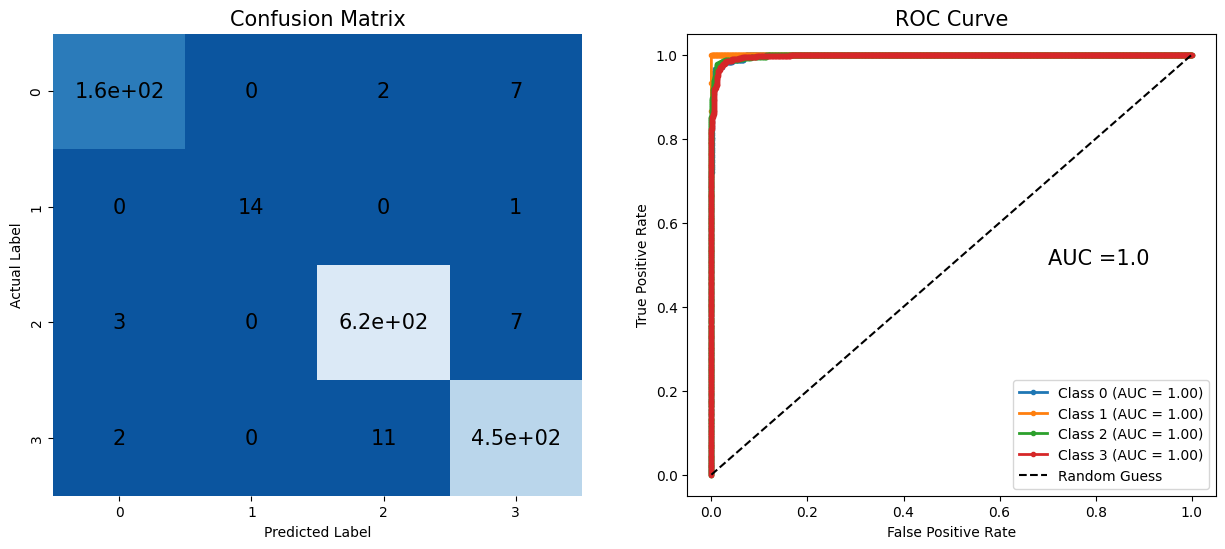


 ___________________________________________________________________________________________________
ExperimentName.FL_CDP_CF_VIT Model Classification Report
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       172
           1       1.00      0.93      0.97        15
           2       0.98      0.98      0.98       634
           3       0.97      0.97      0.97       459

    accuracy                           0.97      1280
   macro avg       0.98      0.96      0.97      1280
weighted avg       0.97      0.97      0.97      1280

___________________________________________________________________________________________________

📊 Consolidated Metrics:
⏱️ Total Duration: 3605.66 sec
✅ Total Energy: 0.15737 kWh
🌍 Total CO₂ Emitted: 0.06767 kg
🧠 Peak CPU RAM: 0.00 GB
🖥️ Peak GPU VRAM: 5.96 GB

 ___________________________________________________________________________________________________


/home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])
INFO :      fit progress: (5, 0.07550039723864757, {'accuracy': 0.97890625}, 2369.2100145860004)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=168389) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=168389) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(ClientA


🕒 Total Time: 40 min 0 sec


In [ ]:
project_root =  os.path.abspath("../..")

ray.shutdown()

ray.init(
    _temp_dir=str(RAY_LOG_DIR),
    runtime_env={
        "env_vars": {
            "PYTHONWARNINGS": "ignore::DeprecationWarning",  # More specific warning filter
            "OMP_NUM_THREADS": "1"  # Prevents thread oversubscription
        },
        "working_dir": project_root,
        'excludes': ['data', '.cache', '.docker', '.local', 'logs/model']
    },
    ignore_reinit_error=True
)

start_time = time.perf_counter()

run_simulation(
    server_app = server,
    client_app = client,
    num_supernodes = fed_config.get("num_clients"),
    backend_config=backend_setup
)


end_time = time.perf_counter()
duration = end_time - start_time
print(f"\n🕒 Total Time: {duration // 60:.0f} min {duration % 60:.0f} sec")

ray.shutdown()